In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV
from joblib import dump, load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

In [16]:
data = pd.read_csv("training_data_with_player_direction.csv")

C:\Users\Tad\AppData\Local\Temp\ipykernel_5256\574075872.py:1: DtypeWarning: Columns (389) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("training_data_with_player_direction.csv")


In [17]:
# Transform Positions
data_transformed = data
data_transformed['play_direction_numerical'] = 1
data_transformed.loc[data_transformed['playDirection'] == 'left', 'play_direction_numerical'] = -1
delta_cols = []
field = {'x': 120.0, 'y': 53.3}
for var_type in ['x', 'y', 's', 'a', 'dir', 'dis', 'o']: # note that magnitude vars (like speed and acceleration) are omitted.
    for pos in ['LT', 'LG', 'C', 'RG', 'RT']:
        col_name = var_type + "_0_" + pos
        for time in range(1, 11): # exclude 0, include 1.0
            time = round(time * 0.1, 1) # working with decimals
            time_str = str(time)
            if time == 1:
                time_str = '1'
            col_name = var_type + "_" + str(time_str) + "_" + pos
            ### Absolute xy transformation
            if var_type == 'x' or var_type == 'y':
                val = data_transformed[col_name]
                newVal = round(field[var_type] - val,2)
                # print(var_type, ": ", val[3], " -> ", newVal[3])
                data_transformed[col_name] = newVal
            ### Done absolute xy transformation

            # print(col_name)
            prev_time = round(time - 0.1, 1)
            prev_time_str = str(prev_time)
            if prev_time == 0:
                prev_time_str = '0' # not '0.0'
            prev_time_col_name = var_type + "_" + str(prev_time_str) + "_" + pos
            delta_col_name = 'delta_' + col_name
            delta_cols.append(col_name) # REMOVE... FLAG
            #delta_cols.append(delta_col_name)
            data_transformed[delta_col_name] = (data_transformed[col_name] - data_transformed[prev_time_col_name]) * data_transformed['play_direction_numerical']

# data_transformed.to_csv("data_transformed.csv")
# data_transformed[['x_0.1_LT', 'x_0_LT', 'delta_x_0.1_LT', 'playDirection']] # quick check

C:\Users\Tad\AppData\Local\Temp\ipykernel_5256\2470496772.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_transformed[delta_col_name] = (data_transformed[col_name] - data_transformed[prev_time_col_name]) * data_transformed['play_direction_numerical']
C:\Users\Tad\AppData\Local\Temp\ipykernel_5256\2470496772.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_transformed[delta_col_name] = (data_transformed[col_name] - data_transformed[prev_time_col_name]) * data_transformed['play_direction_numerical']
C:\Users\Tad

In [18]:
# Principal Component Analysis
cols_of_interest = ['action_time'] + delta_cols
data_all = data_transformed.dropna()
data = data_all.select_dtypes(['number'])
data = data[cols_of_interest]
x = data.loc[:, data.columns != 'action_time']
y = data['action_time']
num_comps = 90
pca = PCA(n_components = num_comps)
print("pca fitting")
principal_components = pca.fit_transform(x)
principal_components_df = pd.DataFrame(principal_components)
print(principal_components_df)
# principal_components_df.to_csv("35_principal_components_time_to_throw.csv")

pca fitting
              0           1           2           3           4           5   \
0     868.528735  170.715698  -32.135742  -91.272848  -53.315352   85.623197   
1    -915.882077  -99.994440  -78.576393  318.454500  -50.451545  -16.284341   
2    -956.446706 -109.214625 -121.646726   79.445065   70.565626  -33.040352   
3    -544.396298  576.019599  -59.631999  -51.720919 -231.189003  -98.468564   
4    -953.289319   -8.334266  -21.652183  -54.020467  -44.917910  -12.389357   
...          ...         ...         ...         ...         ...         ...   
1115  630.998943 -208.594955 -270.795508 -188.632289 -130.135503  494.606550   
1116  911.516503   82.038329   81.934401 -180.489938  -55.288090   32.004023   
1117  773.367672  -60.530018  -64.969258 -117.654189   35.197842   49.025149   
1118  896.724399   37.307275   66.013066  -99.426636  -42.342443  -14.582152   
1119 -689.621717  140.821887 -221.547197 -163.626812  -65.652749  -42.070167   

              6          7 

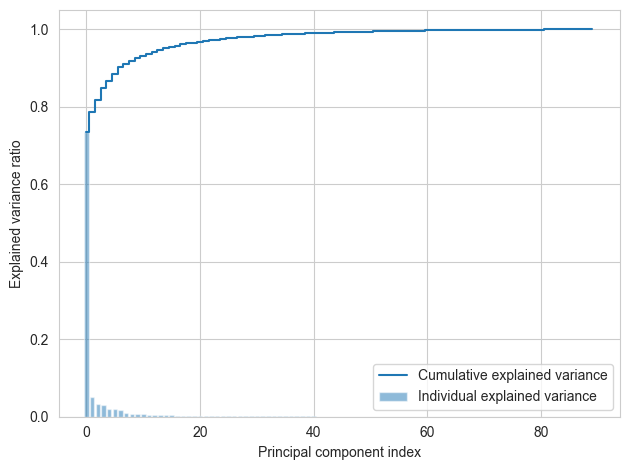

In [19]:
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [20]:
print(data['x_0.2_LT'])

0       78.86
1       10.38
2       41.67
3       69.36
4       64.14
        ...  
1115    91.44
1116    92.04
1117    78.66
1118    79.00
1119    78.11
Name: x_0.2_LT, Length: 1120, dtype: float64


In [21]:
pca_corr_cols = ['principal_component'] + cols_of_interest
print(data.columns)
print(principal_components_df.columns)
pca_correlations = pd.DataFrame(columns = pca_corr_cols)
counter = 0
for col in cols_of_interest:
    counter = counter + 1
    print(counter)
    entry = [col]
    for pc in range(num_comps):
        correlation = np.corrcoef(data[col], principal_components_df[pc], rowvar = False)
        entry.append(correlation)
    entry = pd.Series(entry)
    #pca_correlations = pca_correlations.append(entry)
    pca_correlations = pd.concat([pca_correlations, entry], axis = 1)


Index(['action_time', 'x_0.1_LT', 'x_0.2_LT', 'x_0.3_LT', 'x_0.4_LT',
       'x_0.5_LT', 'x_0.6_LT', 'x_0.7_LT', 'x_0.8_LT', 'x_0.9_LT',
       ...
       'o_0.1_RT', 'o_0.2_RT', 'o_0.3_RT', 'o_0.4_RT', 'o_0.5_RT', 'o_0.6_RT',
       'o_0.7_RT', 'o_0.8_RT', 'o_0.9_RT', 'o_1_RT'],
      dtype='object', length=351)
RangeIndex(start=0, stop=90, step=1)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189


In [22]:
print(pca_correlations)

   principal_component action_time x_0.1_LT x_0.2_LT x_0.3_LT x_0.4_LT  \
0                  NaN         NaN      NaN      NaN      NaN      NaN   
1                  NaN         NaN      NaN      NaN      NaN      NaN   
2                  NaN         NaN      NaN      NaN      NaN      NaN   
3                  NaN         NaN      NaN      NaN      NaN      NaN   
4                  NaN         NaN      NaN      NaN      NaN      NaN   
..                 ...         ...      ...      ...      ...      ...   
86                 NaN         NaN      NaN      NaN      NaN      NaN   
87                 NaN         NaN      NaN      NaN      NaN      NaN   
88                 NaN         NaN      NaN      NaN      NaN      NaN   
89                 NaN         NaN      NaN      NaN      NaN      NaN   
90                 NaN         NaN      NaN      NaN      NaN      NaN   

   x_0.5_LT x_0.6_LT x_0.7_LT x_0.8_LT  ...  \
0       NaN      NaN      NaN      NaN  ...   
1       NaN      

In [23]:
# Prep Train and Test Data
label = data['action_time']
principal_components_df['action_time'] = label
X = principal_components_df.loc[:, principal_components_df.columns != 'action_time']
y = principal_components_df['action_time']
#X = data.loc[:, data.columns != 'action_time']
#y = data['action_time']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("completed train-test split")

completed train-test split


In [ ]:
print(datetime.now())
random_grid = { # FLAG
    'bootstrap': [True, False],
    'max_depth': [5, 10, 20, 50],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [3, 5, 10],
    'min_samples_split': [3, 5, 15],
    'n_estimators': [250, 500, 1000, 2000],
}

rf_tuning = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf_tuning, param_distributions = random_grid, n_iter = 30, cv = 3, verbose = 2, random_state = 42, n_jobs = -1)
rf_fit_output = rf_random.fit(x_train, y_train)
print(datetime.now())

2022-12-15 13:01:23.980934
Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [ ]:
rf_tuned = rf_fit_output.best_estimator_
rf_tuned.fit(x_train, y_train)

In [ ]:
# Use the forest's predict method on the test data
predictions = rf_tuned.predict(x_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')
print('MSE: ', mean_squared_error(y_test, predictions))
print('R^2: ', rf_tuned.score(x_test, y_test))

In [ ]:
from sklearn.inspection import permutation_importance
import time

start_time = time.time()
result = permutation_importance(
    rf_tuned, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=cols_of_interest)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [ ]:
# Import tools needed for visualization
# from sklearn.tree import export_graphviz
# import pydot# Pull out one tree from the forest
# tree = rf_tuned.estimators_[5]# Import tools needed for visualization
# from sklearn.tree import export_graphviz
# import pydot# Pull out one tree from the forest
# tree = rf_tuned.estimators_[5]# Export the image to a dot file
# features = [col for col in data.columns if col != 'action_time']
# export_graphviz(tree, out_file = 'tree.dot', feature_names = features, rounded = True, precision = 1)# Use dot file to create a graph
# (graph, ) = pydot.graph_from_dot_file('tree.dot')# Write graph to a png file
# # print(graph)
# graph.write_png('tree.png')

In [ ]:
test_set_with_predictions = pd.DataFrame(columns = {'actual': y_test, 'predicted': predictions})
test_set_with_predictions['actual'] = y_test
test_set_with_predictions['predicted'] = predictions
test_set_with_predictions.to_csv("test_set_with_predictions.csv")
#for i in range(len(y_test)):
#    print(y_test[i], predictions[i])